In [207]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_random_state
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
#import umap
import umap.umap_ as umap
from keras.optimizers import Adam
from keras.regularizers import l1

In [2]:
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 

In [165]:
y

,Class
0,1
1,1
2,1
3,1
4,1
...,...
4596,0
4597,0
4598,0
4599,0


In [3]:
#drop the columns that are not frequency counts
X = X.drop(X.columns[54:57], axis=1)

In [181]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#transform to one hot encoding
y_train_normal = y_train
y_test_normal = y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
original_dim = X_train.shape[1]
latent_dim = 32
intermediate_dim = 1024

In [6]:
#input layer
inputs = Input(shape=(original_dim,))
labels = Input(shape=(2,))

#dense layer with relu activation
h = Dense(intermediate_dim, activation='relu')(inputs)

In [7]:
## encoder model ##

# parameters of latent distribution
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [8]:
# sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
# sample vector from latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [10]:
# classifier
classifier_h = Dense(intermediate_dim, activation='relu')(z)
classifier_output = Dense(2, activation='softmax')(classifier_h)

In [11]:
### Decoder model ###

# Dense layer with relu activation takes sampled latent space vector z and maps it to an intermediate space
decoder_h = Dense(intermediate_dim, activation='relu')

# Dense layer with sigmoid activation takes the intermediate space vector and maps it back to the original dimension
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [12]:
# VAE model
vae = Model([labels, inputs], [x_decoded_mean,classifier_output])

In [13]:
# Define the VAE loss

# Reconstruction loss
#rec_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
rec_loss = K.mean(K.square(inputs - x_decoded_mean), axis=-1)
# KL divergence loss 
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#classifier loss
class_loss = binary_crossentropy(labels, classifier_output)
# Total loss
vae_loss = K.mean(rec_loss + 0.1*kl_loss + class_loss)



In [14]:
vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.000001)
vae.compile(optimizer=optimizer)

In [15]:
# Train the VAE model
vae.fit([y_train, X_train], epochs=250, batch_size=64, validation_data=([y_test, X_test], None))

Epoch 1/250
58/58 [==============================] - 2s 10ms/step - loss: 1.7341 - val_loss: 1.7726
Epoch 2/250
58/58 [==============================] - 0s 5ms/step - loss: 1.7258 - val_loss: 1.7621
Epoch 3/250
58/58 [==============================] - 0s 5ms/step - loss: 1.7190 - val_loss: 1.7484
Epoch 4/250
58/58 [==============================] - 0s 5ms/step - loss: 1.7057 - val_loss: 1.7390
Epoch 5/250
58/58 [==============================] - 0s 5ms/step - loss: 1.7022 - val_loss: 1.7395
Epoch 6/250
58/58 [==============================] - 0s 4ms/step - loss: 1.7005 - val_loss: 1.7280
Epoch 7/250
58/58 [==============================] - 0s 6ms/step - loss: 1.6848 - val_loss: 1.7279
Epoch 8/250
58/58 [==============================] - 0s 4ms/step - loss: 1.6758 - val_loss: 1.7130
Epoch 9/250
58/58 [==============================] - 0s 5ms/step - loss: 1.6786 - val_loss: 1.7097
Epoch 10/250
58/58 [==============================] - 0s 5ms/step - loss: 1.6681 - val_loss: 1.6995
Epoch 11

In [16]:
# Build the encoder model 
encoder = Model(inputs, [z_mean, z_log_var])
z_mean, z_log_var = encoder.predict(X_test, batch_size=64)

15/15 [==============================] - 0s 1ms/step


In [17]:
# locate data points in latent space
data_point = X_test.loc[0]
data_point_encoding = [z_mean[0], z_log_var[0]]

In [18]:
# draw 5 samples from the latent distribution
epsilon = np.random.normal(size=(5, latent_dim))
z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * epsilon


In [75]:
z_sample.shape

(5, 32)

In [19]:
# build decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)


In [20]:
# decode samples
x_decoded = decoder.predict(z_sample)

1/1 [==============================] - 0s 89ms/step


In [21]:
# build classifier model
classifier = Model(inputs, classifier_output)
classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# evaluate classifier
score = classifier.evaluate(X_test, y_test, batch_size=64)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


15/15 [==============================] - 0s 2ms/step - loss: 0.5805 - accuracy: 0.7166
Test loss: 0.5805380344390869
Test accuracy: 0.7166123986244202


In [22]:
# visualize decoded samples and original data point
print("Original data point:")
print(np.array(data_point))
print("Decoded sample:")
print(x_decoded[0])

Original data point:
[0.    0.64  0.64  0.    0.32  0.    0.    0.    0.    0.    0.    0.64
 0.    0.    0.    0.32  0.    1.29  1.93  0.    0.96  0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.778 0.    0.   ]
Decoded sample:
[0.23650414 0.28582254 0.32673967 0.34855968 0.37301114 0.2112516
 0.31649342 0.28934863 0.31832492 0.34089157 0.2703188  0.49668726
 0.26334217 0.26854506 0.23869948 0.31039023 0.25791612 0.30440482
 0.76011837 0.24552813 0.62386113 0.3204471  0.2530246  0.1783087
 0.54065424 0.34510034 0.5308837  0.26688957 0.25373334 0.26663566
 0.27894086 0.30488944 0.21999572 0.29132187 0.3111428  0.20655648
 0.2567976  0.25929332 0.24219736 0.3138599  0.2642288  0.32383984
 0.24423805 0.25238705 0.3622034  0.3019418  0.2425898  0.23823753
 0.24700013 0.21492694 0.2161373  0.36719018 0.3128848  0.21276778]


In [23]:
visualization_data = np.vstack(list(np.array(X_test)[1:])+ [data_point] + list(x_decoded))

In [24]:
# Create labels for the visualization
labels = ["other data point in X_test"]*len(X_test[1:]) + ["Original data point"] + ["Generated"]*5
colors = ["darkslategray"]*len(X_test[1:]) + ["red"] + ["sienna"]*5

In [25]:
# Apply UMAP for visualization
umap_model = umap.UMAP(n_components=2)
visualized_data = umap_model.fit_transform(visualization_data)

c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\matplotlib\collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


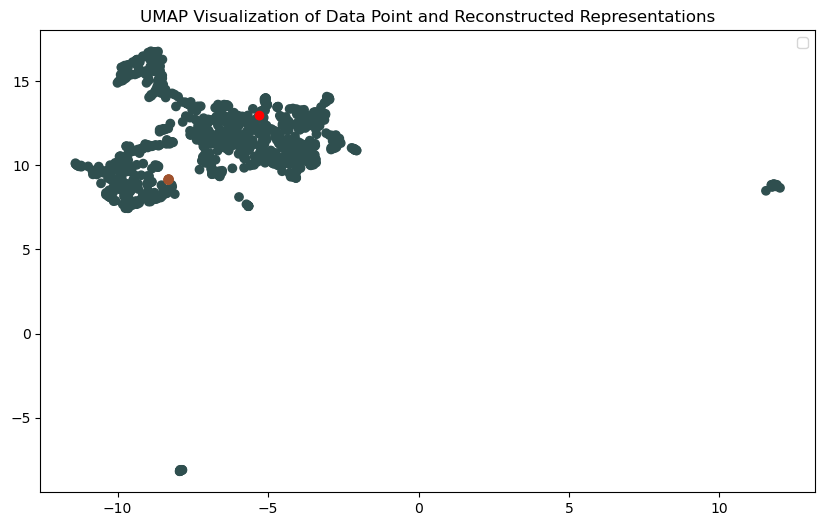

In [26]:
# Plot the visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(visualized_data[:, 0], visualized_data[:, 1], c=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.title('UMAP Visualization of Data Point and Reconstructed Representations')
plt.show()

# GRADE 2

### Generating new samples

In [208]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train_normal)

class VAE_SLIME():
    def __init__(self, x_instance, vae_encoder_model = encoder, vae_decoder_model = decoder, K=10, N=1000, latent_dim = latent_dim, classifier_model = clf, num_features = 10, random_state=424):
        self.x_instance = x_instance
        self.vae_encoder_model = vae_encoder_model
        self.vae_decoder_model = vae_decoder_model
        self.K = K
        self.N = N
        self.latent_dim = latent_dim
        self.classifier_model = classifier_model
        self.random_state = check_random_state(random_state)
        self.epsilon = self.random_state.normal(size=(1, latent_dim), loc = 0, scale = 1)
        self.num_features = num_features


    def get_explanation(self, Z):
        
        Y = []
        W = []
        F = []

        #Train a Local Model
        for z in Z:
            y_pred = self.classifier_model.predict(z)
            Y.append(y_pred)
            W.append(self.weighting_function(self.x_instance, z))
    
        Y = np.array(Y)
        W = np.array(W)
        F = self.feature_importance(Z, Y)
        # F = np.array(F)

        # Combine explanations using a weighted linear model
        g = LogisticRegression()
        g.fit(F, Y, sample_weight=W)

        return g, F, W, Y
        
    def get_samples(self, X_train):

        Z = []

        # Select Neighbors using KNN
        neighbors = self.select_neighbors(self.x_instance, X_train)

        # Generate Samples
        while len(Z) < self.N:
            data = self.generate_data(neighbors)
            Z.extend(data)
            neighbors = data.reshape(self.K, -1)

        return Z

    def select_neighbors(self, x_instance, X_train):
        # Use KNN to find the nearest neighbors
        knn = NearestNeighbors(n_neighbors=self.K, metric='euclidean')
        knn.fit(X_train)
        distances, indices = knn.kneighbors(x_instance.reshape(1, -1))
        neighbors = X_train.reset_index(drop = True).iloc[indices.flatten()]
        return neighbors
    
    def generate_data(self, neighbors):
        # Use the VAE model to generate samples for neighbors
        z_samples = []
        z_mean, z_log_var = self.vae_encoder_model.predict(neighbors, batch_size=64)
        for i in range(self.K):
            data_point_encoding = [z_mean[i], z_log_var[i]]
            z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * self.epsilon
            z = self.vae_decoder_model.predict(z_sample)
            z_samples.append(z)
        return np.array(z_samples)

    def weighting_function(self, x_instance, z):
        # Weighting function
        kernel_width = np.sqrt(x_instance.shape[0]) #this is the default in LimeTabularExplainer
        distance = np.linalg.norm(x_instance - z) #euclidean distance
        weight = np.exp(-distance**2 / (kernel_width**2))
        return weight

    def feature_importance(self, Z, Y):
        # Select the top n_features features using a single Lasso model
        Z_stacked = np.vstack(Z)
        Z_df = pd.DataFrame(Z_stacked)
        Z_df.columns = X_train.columns
        lasso = LassoCV(cv=5)
        lasso.fit(Z_df, Y)
        important_features = np.argsort(np.abs(lasso.coef_))[-self.num_features:]
        return Z_df.iloc[:, important_features]

# Example usage:
# lime = LimeVAE(vae_model, classifier_model)
# explanation = lime.lime_explanation(x_instance, X_train)

c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [216]:
data_point = np.array(X_test.iloc[1])
vae_slime = VAE_SLIME(data_point)
samples = vae_slime.get_samples(X_train)

1/1 [==============================] - 0s 17ms/step


c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


In [217]:
explanation, features, weights, y = vae_slime.get_explanation(samples)

c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.w

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [220]:
data_point

array([0.   , 0.   , 0.33 , 0.   , 0.99 , 0.99 , 0.33 , 0.33 , 0.   ,
       0.   , 0.   , 0.33 , 0.33 , 0.   , 0.   , 0.33 , 0.33 , 0.   ,
       1.98 , 0.   , 3.3  , 0.   , 0.   , 0.33 , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.33 ,
       0.   , 0.   , 0.   , 0.   , 0.108, 0.   , 0.   , 0.162, 0.054])

In [219]:
samples

[array([[0.20757936, 0.28450435, 0.21713834, 0.3075521 , 0.34758073,
         0.14666685, 0.15879296, 0.18338187, 0.29566792, 0.25219864,
         0.18897964, 0.46374202, 0.16235375, 0.14841187, 0.12297656,
         0.30480865, 0.22852355, 0.26772308, 0.88627166, 0.17421922,
         0.81099457, 0.2532416 , 0.16003737, 0.17512366, 0.5200591 ,
         0.23273589, 0.4759094 , 0.18426098, 0.18228759, 0.19436207,
         0.22662053, 0.18680428, 0.18030958, 0.19841534, 0.2350977 ,
         0.1398743 , 0.158601  , 0.16833268, 0.13830563, 0.20282042,
         0.16779694, 0.23221743, 0.2527849 , 0.1684337 , 0.22237033,
         0.32204944, 0.15319537, 0.23025557, 0.20326304, 0.23534814,
         0.11539263, 0.26700795, 0.21069369, 0.13602777]], dtype=float32),
 array([[0.2089456 , 0.28562412, 0.21692424, 0.30836526, 0.34477392,
         0.14759149, 0.15911222, 0.18229206, 0.2931717 , 0.25269574,
         0.18970047, 0.46414047, 0.16183738, 0.14842166, 0.12242325,
         0.30474126, 0.22863

In [218]:
y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [200]:
features

,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_report,char_freq_#
0,0.267528,0.876323,0.176933,0.797509,0.268674,0.163516,0.178091,0.529907,0.149969,0.137379
1,0.267332,0.875546,0.177406,0.796018,0.269049,0.163917,0.177946,0.530826,0.150179,0.137729
2,0.267397,0.875817,0.177219,0.796572,0.268745,0.163668,0.177677,0.530559,0.149930,0.137560
3,0.266349,0.876362,0.177826,0.796887,0.267786,0.163552,0.177742,0.529204,0.150130,0.136781
4,0.267214,0.877797,0.176362,0.799404,0.265219,0.162375,0.176668,0.529135,0.149097,0.136441
...,...,...,...,...,...,...,...,...,...,...
995,0.266852,0.870375,0.176507,0.784675,0.275347,0.167395,0.182402,0.552013,0.151807,0.139262
996,0.266852,0.870375,0.176507,0.784675,0.275347,0.167395,0.182402,0.552013,0.151807,0.139262
997,0.266852,0.870375,0.176507,0.784675,0.275347,0.167395,0.182402,0.552013,0.151807,0.139262
998,0.266852,0.870375,0.176507,0.784675,0.275347,0.167395,0.182402,0.552013,0.151807,0.139262


In [195]:
explanation.coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [179]:
clf.predict(data_point.reshape(1, -1))

c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [121]:
import pandas as pd
df = pd.DataFrame(np.vstack(samples))
df.columns = X_train.columns
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
0,0.210744,0.293765,0.216077,0.309971,0.340659,0.152543,0.162790,0.182768,0.292717,0.256187,...,0.234031,0.323081,0.153496,0.234665,0.209574,0.243101,0.117184,0.274921,0.206960,0.137379
1,0.211179,0.294203,0.216102,0.310376,0.340975,0.153275,0.163460,0.183009,0.293009,0.256509,...,0.235383,0.322948,0.153866,0.234777,0.209534,0.243900,0.117297,0.275782,0.206742,0.137729
2,0.210952,0.293839,0.215970,0.310168,0.340998,0.152962,0.163278,0.182920,0.292958,0.256328,...,0.234960,0.322875,0.153673,0.234688,0.209427,0.243546,0.117191,0.275450,0.206652,0.137560
3,0.210926,0.294027,0.215954,0.309576,0.340598,0.152235,0.162729,0.182106,0.292993,0.255653,...,0.233993,0.322488,0.153610,0.233577,0.210230,0.242437,0.117074,0.275388,0.207508,0.136781
4,0.210621,0.293068,0.215991,0.309419,0.341093,0.151160,0.162261,0.181578,0.292737,0.255090,...,0.231920,0.322082,0.153003,0.232876,0.209177,0.242057,0.116127,0.273895,0.207205,0.136441


In [64]:
neighbors = vae_samples.select_neighbors(data_point, X_train)

c:\Users\samoi\anaconda3\envs\orange3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [69]:
def generate_data(neighbors, vae_encoder_model = encoder, vae_decoder_model = decoder, K=10, N=1000, latent_dim = latent_dim, random_state=424):
        # Step 4: Generate data from VAE
        # Use the VAE model to generate N samples
        random_state = check_random_state(random_state)
        epsilon = random_state.normal(size=(N, latent_dim))
        z_samples = []
        z_mean, z_log_var = vae_encoder_model.predict(neighbors, batch_size=64)
        for i in range(K):
            data_point_encoding = [z_mean[i], z_log_var[i]]
            z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * epsilon
            #z = vae_decoder_model.predict(z_sample.flatten())
            #z_samples.append(z)
        #return np.array(z_samples)
        return z_sample

In [82]:
sample_n = generate_data(neighbors)

1/1 [==============================] - 0s 21ms/step


In [102]:
sample_n.reshape(10, -1).shape	

(10, 54)

In [81]:
def generate_data(neighbors, vae_encoder_model = encoder, vae_decoder_model = decoder, K=10, N=1000, latent_dim = latent_dim, random_state=42):
        # Step 4: Generate data from VAE
        # Use the VAE model to generate N samples
        random_state = check_random_state(random_state)
        epsilon = random_state.normal(size=(1, latent_dim), loc = 0, scale = 1)
        z_samples = []
        z_mean, z_log_var = vae_encoder_model.predict(neighbors, batch_size=64)
        for i in range(K):
            data_point_encoding = [z_mean[i], z_log_var[i]]
            z_sample = data_point_encoding[0] + np.exp(data_point_encoding[1] / 2) * epsilon
            z = vae_decoder_model.predict(z_sample)
            z_samples.append(z)
        return np.array(z_samples)

In [101]:
encoder.predict(sample_n.reshape(10, 54), batch_size=64)

1/1 [==============================] - 0s 64ms/step


[array([[ 1.95878465e-02,  9.34389010e-02, -2.61079334e-02,
         -7.08651030e-03, -3.45110744e-02, -1.36826029e-02,
          6.49243873e-03, -6.32312968e-02, -1.26723826e-01,
         -7.80500844e-02, -5.81002515e-03,  4.46632318e-02,
          2.75546182e-02,  5.56917004e-02, -2.60745846e-02,
          4.64303140e-03,  1.35808229e-03,  2.92226276e-03,
          6.08489849e-03,  2.30328413e-03, -6.53879866e-02,
         -1.86231658e-02, -7.35791549e-02,  1.19648762e-02,
         -7.47945532e-02,  2.82660089e-02,  1.69987679e-02,
         -2.29330324e-02,  2.32755148e-04,  7.88126979e-03,
          6.37899116e-02, -6.50580898e-02],
        [ 1.91868357e-02,  9.31836292e-02, -2.60949805e-02,
         -7.01291719e-03, -3.44148055e-02, -1.37756756e-02,
          6.68926071e-03, -6.27780035e-02, -1.26396045e-01,
         -7.78170824e-02, -5.78059535e-03,  4.43072841e-02,
          2.74128020e-02,  5.55135570e-02, -2.57085226e-02,
          4.94671334e-03,  1.42962649e-03,  3.00504244e-

In [100]:
sample_n

array([[[0.22949801, 0.4010102 , 0.27247366, 0.27665868, 0.3587546 ,
         0.18413775, 0.24065599, 0.18620181, 0.2861479 , 0.28293994,
         0.21295996, 0.53256655, 0.1899983 , 0.19604096, 0.16609363,
         0.3429942 , 0.26634896, 0.24980898, 0.840648  , 0.24250083,
         0.6558177 , 0.24865654, 0.22656177, 0.22446916, 0.49193087,
         0.34958205, 0.57905084, 0.21457845, 0.25704178, 0.22786765,
         0.21717642, 0.1686627 , 0.17135654, 0.21302234, 0.2756618 ,
         0.18621717, 0.2445552 , 0.21133606, 0.24437007, 0.19814378,
         0.22592229, 0.26649877, 0.2691471 , 0.19387446, 0.3052245 ,
         0.1808149 , 0.19015183, 0.2222271 , 0.18201885, 0.19596386,
         0.17153096, 0.26308107, 0.2068753 , 0.19087909]],

       [[0.22882433, 0.4013592 , 0.2712609 , 0.27629408, 0.3576893 ,
         0.18404825, 0.24098307, 0.18632387, 0.2857451 , 0.28264585,
         0.21305941, 0.5326153 , 0.1898034 , 0.19591333, 0.16686499,
         0.34218055, 0.26658258, 0.24887647

In [99]:
sample_n.reshape(10, 54)

array([[0.22949801, 0.4010102 , 0.27247366, 0.27665868, 0.3587546 ,
        0.18413775, 0.24065599, 0.18620181, 0.2861479 , 0.28293994,
        0.21295996, 0.53256655, 0.1899983 , 0.19604096, 0.16609363,
        0.3429942 , 0.26634896, 0.24980898, 0.840648  , 0.24250083,
        0.6558177 , 0.24865654, 0.22656177, 0.22446916, 0.49193087,
        0.34958205, 0.57905084, 0.21457845, 0.25704178, 0.22786765,
        0.21717642, 0.1686627 , 0.17135654, 0.21302234, 0.2756618 ,
        0.18621717, 0.2445552 , 0.21133606, 0.24437007, 0.19814378,
        0.22592229, 0.26649877, 0.2691471 , 0.19387446, 0.3052245 ,
        0.1808149 , 0.19015183, 0.2222271 , 0.18201885, 0.19596386,
        0.17153096, 0.26308107, 0.2068753 , 0.19087909],
       [0.22882433, 0.4013592 , 0.2712609 , 0.27629408, 0.3576893 ,
        0.18404825, 0.24098307, 0.18632387, 0.2857451 , 0.28264585,
        0.21305941, 0.5326153 , 0.1898034 , 0.19591333, 0.16686499,
        0.34218055, 0.26658258, 0.24887647, 0.84058356, 0.2

In [87]:
neighbors

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
513,0.0,0.69,0.34,0.0,0.34,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.056,0.0,0.786,0.0,0.0
1270,0.0,0.68,0.34,0.0,0.34,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.055,0.0,0.718,0.0,0.0
3101,0.0,0.71,0.35,0.0,0.35,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.058,0.0,0.700,0.0,0.0
438,0.0,0.64,0.64,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.053,0.0,1.065,0.0,0.0
3354,0.0,0.53,0.53,0.0,0.53,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.087,0.0,0.877,0.0,0.0
1365,0.0,0.71,0.71,0.0,0.35,0.35,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.057,0.0,1.257,0.0,0.0
27,0.0,0.62,0.62,0.0,0.31,0.00,0.0,0.0,0.0,0.0,...,0.31,0.0,0.0,0.0,0.0,0.051,0.0,0.777,0.0,0.0
1089,0.0,0.48,0.48,0.0,0.48,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.080,0.0,0.963,0.0,0.0
2295,0.0,0.44,0.89,0.0,0.44,0.00,0.0,0.0,0.0,0.0,...,0.44,0.0,0.0,0.0,0.0,0.073,0.0,0.807,0.0,0.0
3102,0.0,0.43,0.43,0.0,0.43,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.147,0.0,0.736,0.0,0.0


In [98]:
neighbors.shape

(10, 54)